# Motion Detection

In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import time

import motion_detection as md

In [3]:
path_to_root = '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'
landmarks_version = "versionB"

## Load Video Metadata

In [4]:
video_metadata_df = pd.read_csv(f'{path_to_root}/data/raw/combined/target_dataset_video_metadata.csv')

In [5]:
video_metadata_df.head()

filename   label data_source  sign_id  signer_number  frame_count  \
0  ajudar_ne_1.mp4  ajudar          ne        2              1           44   
1  ajudar_sb_2.mp4  ajudar          sb        1              1           79   
2  ajudar_uf_3.mp4  ajudar          uf        0              1          115   
3  ajudar_vl_4.mp4  ajudar          vl        0              1          141   
4  ajudar_vl_5.mp4  ajudar          vl        0              2          289   

        fps  duration_sec  width  height  needs_flip  
0  12.00000      3.666667    240     176       False  
1  29.97003      2.635967   1280     720       False  
2  29.97003      3.837167    480     270       False  
3  29.97003      4.704700   1920    1080       False  
4  29.97003      9.642967   1920    1080       False

## Motion Detection Demo

### Choose a row from the video metadata dataframe

In [70]:
i = 0
row = video_metadata_df.iloc[i]
path = f"{path_to_root}/data/raw/combined/videos/{row.filename}"
landmarks_path = f"{path_to_root}/data/interim/RawPoseLandmarks/{landmarks_version}/{row.filename.replace('.mp4', '.npy')}"
fps = row.fps

### Measure Motion 
Methods:
- Basic
- Background Subtraction
- Landmarks ()

In [71]:
# Measure basic motion
start_time = time.time()
mm_basic_raw = md.measure_motion_basic(path)
mm_basic_normalized = md.normalize_list_of_data(mm_basic_raw)
basic_time = time.time() - start_time
print(f"Basic motion detection took {basic_time:.2f} seconds")

# Measure background subtraction
start_time = time.time()
mm_background_subtraction_raw = md.measure_motion_background_subtraction(path)
mm_background_subtraction_normalized = md.normalize_list_of_data(mm_background_subtraction_raw)
background_time = time.time() - start_time
print(f"Background subtraction method took {background_time:.2f} seconds")

# Measure landmarks difference
start_time = time.time()
mm_landmarks_raw = md.measure_landmark_change(landmarks_path, use_pose=True, use_face=False, use_hands=True, combination_method='mean')
mm_landmarks_normalized = md.normalize_list_of_data(mm_landmarks_raw)
landmarks_time = time.time() - start_time
print(f"Landmarks difference method took {landmarks_time:.2f} seconds")


Basic motion detection took 0.02 seconds
Background subtraction method took 0.06 seconds
Landmarks difference method took 0.01 seconds


In [72]:

# Combine the three motion measurements with a weighted average (weights 0.3, 0.3, 0.4)
mm_combined_normalized = md.weighted_average_motion(
    [mm_basic_normalized, mm_background_subtraction_normalized, mm_landmarks_normalized],
    weights = [0.3, 0.3, 0.4],
    )

print(F"\nTotal processing time: {basic_time + landmarks_time + background_time:.2f} seconds")


Total processing time: 0.09 seconds


#### Take moving average for smoother results

In [73]:
mm_basic = md.moving_average(mm_basic_normalized, fps, window_duration=0.334)
mm_background_subtraction = md.moving_average(mm_background_subtraction_normalized, fps, window_duration=0.334)
mm_landmarks = md.moving_average(mm_landmarks_normalized, fps, window_duration=0.334)

# Combine the three motion measurements with a weighted average (weights 0.3, 0.3, 0.4)
mm_combined = md.moving_average(mm_combined_normalized, fps, window_duration=0.334)

window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size


## Motion Visualization

### Video example with the normalised motion measurements

In [74]:
md.play_video_with_motion_graph(
    path,
    [mm_basic_normalized, mm_background_subtraction_normalized, mm_landmarks_normalized, mm_combined_normalized],
    graph_height = 400,
    figsize = (6, 2),
    dpi = 150,
    legend_labels = ['Basic', 'Background Sub', 'Landmarks', 'Weighted Avg'],
    alpha = 1
)


Video ended. Press 'r' to replay or 'q' to quit.
CLOSING THE WINDOW BY CLICKING X WILL KEEP THE CELL RUNNING!


### Video example with the normalised motion measurements, with a moving average applied

In [ ]:
md.play_video_with_motion_graph(
    path,
    [mm_basic, mm_background_subtraction, mm_landmarks, mm_combined],
    graph_height = 400,
    figsize = (6, 2),
    dpi = 150,
    legend_labels = ['Basic', 'Background Sub', 'Landmarks', 'Weighted Avg'],
    alpha = 1
)


Video ended. Press 'r' to replay or 'q' to quit.
CLOSING THE WINDOW BY CLICKING X WILL KEEP THE CELL RUNNING!


## Exploring the landmarks method

In [30]:
pose_params = [True, False]
face_params = [False]
hands_params = [True, False]
method_params = ['mean', 'rms', 'median']
method_measurements = {}
for pose in pose_params:
    for face in face_params:
        for hands in hands_params:
            for method in method_params:
                # if all are false, skip
                if not pose and not face and not hands:
                    continue
                name = ''
                if pose:
                    name += 'pose_'
                if face:
                    name += 'face_'
                if hands:
                    name += 'hands_'
                name += method
                measurements = md.measure_landmark_change(landmarks_path, pose, face, hands, method)
                method_measurements[name] = md.normalize_list_of_data(measurements)

In [31]:
frame_numbers = [7, 8, 9, 33, 34, 35]
frame_numbers = [8,34,]

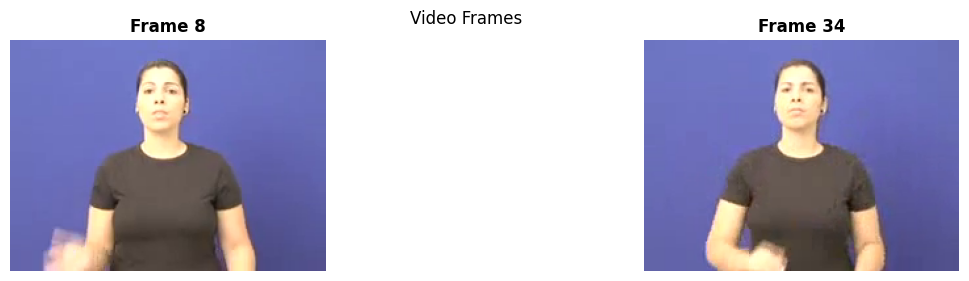

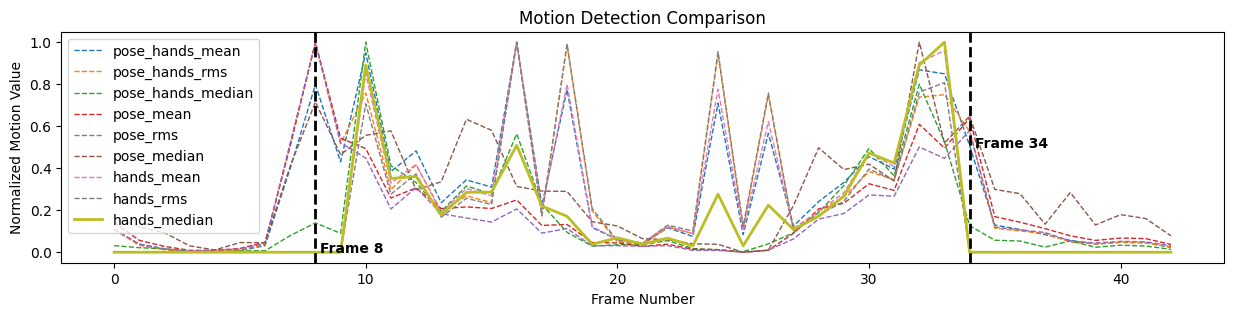

In [32]:
md.show_multiple_frames_one_plot(
    path,
    frame_numbers, 
    list(method_measurements.values()),
    figsize = (15, 3),
    legend_labels = list(method_measurements.keys()),
    )

In [25]:
pose_params = [True]
face_params = [False]
hands_params = [True]
method_params = ['mean', 'rms', 'median']
method_measurements = {}
for pose in pose_params:
    for face in face_params:
        for hands in hands_params:
            for method in method_params:
                # if all are false, skip
                if not pose and not face and not hands:
                    continue
                name = ''
                if pose:
                    name += 'pose_'
                if face:
                    name += 'face_'
                if hands:
                    name += 'hands_'
                name += method
                measurements = md.measure_landmark_change(landmarks_path, pose, face, hands, method)
                method_measurements[name] = md.normalize_list_of_data(measurements)

In [26]:
frame_numbers = [7, 8, 9, 33, 34, 35]
frame_numbers = [8,34,]

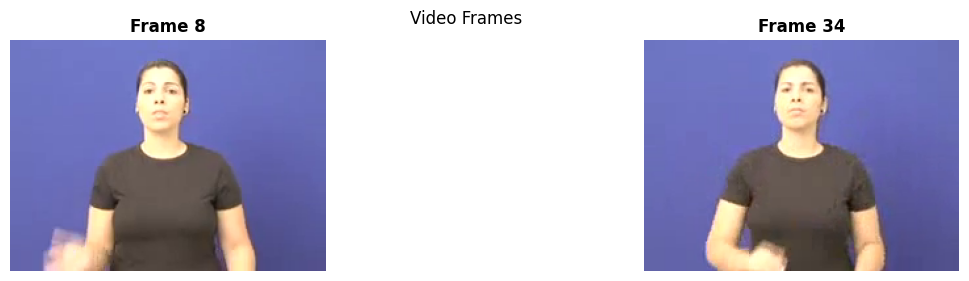

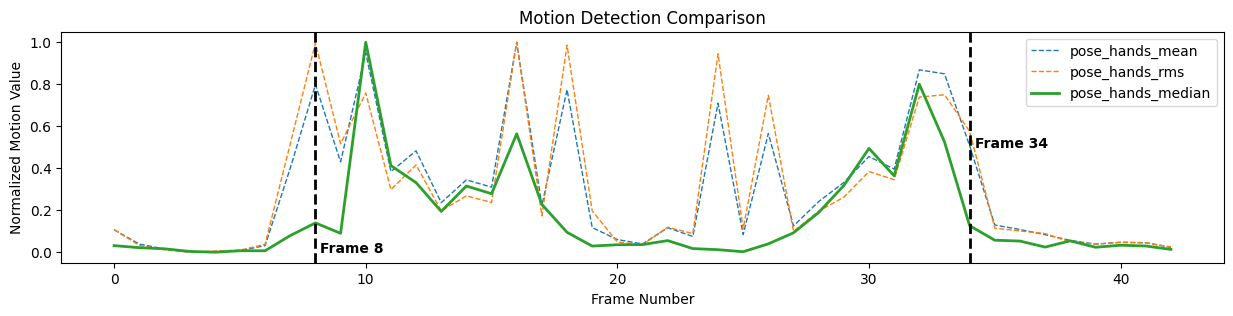

In [29]:
md.show_multiple_frames_one_plot(
    path,
    frame_numbers, 
    list(method_measurements.values()),
    figsize = (15, 3),
    legend_labels = list(method_measurements.keys()),
    )

### Frame Analysis

#### Individual Frame

In [33]:
frame_number = 10
frame = md.get_frame(path, frame_number)

(-0.5, 1279.5, 1119.5, -0.5)

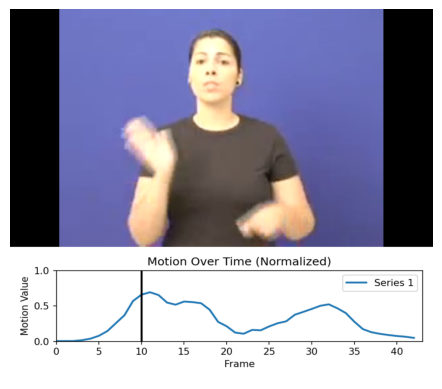

In [34]:
plot = md.create_frame_with_motion_graph(
    frame,
    [mm_combined],
    frame_number,
    target_width = 1280,
    target_height = 720,
    graph_height = 400,
    figsize = (6, 2),
    dpi = 150
)
plt.imshow(plot[:,:,::-1])
plt.axis('off')

### Multiple Frames

In [181]:
frame_numbers = [10, 14, 20, 30,  51]

#### Multiple Frames - One Motion Measurement Plot

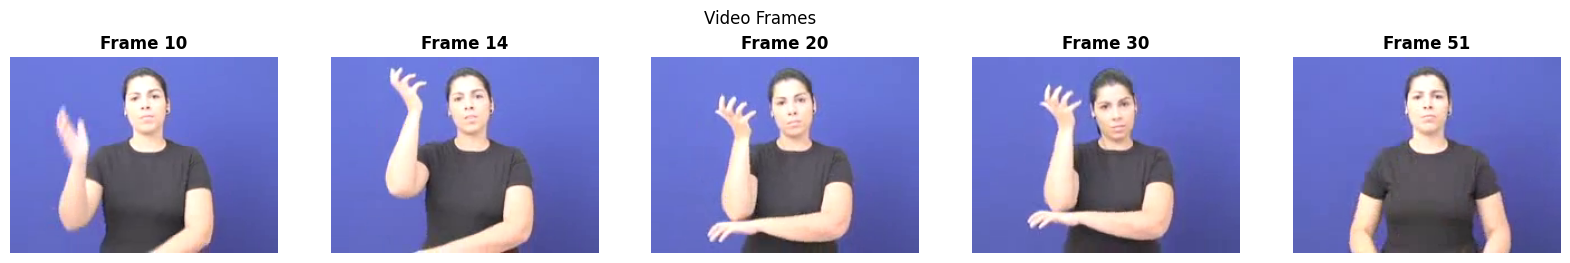

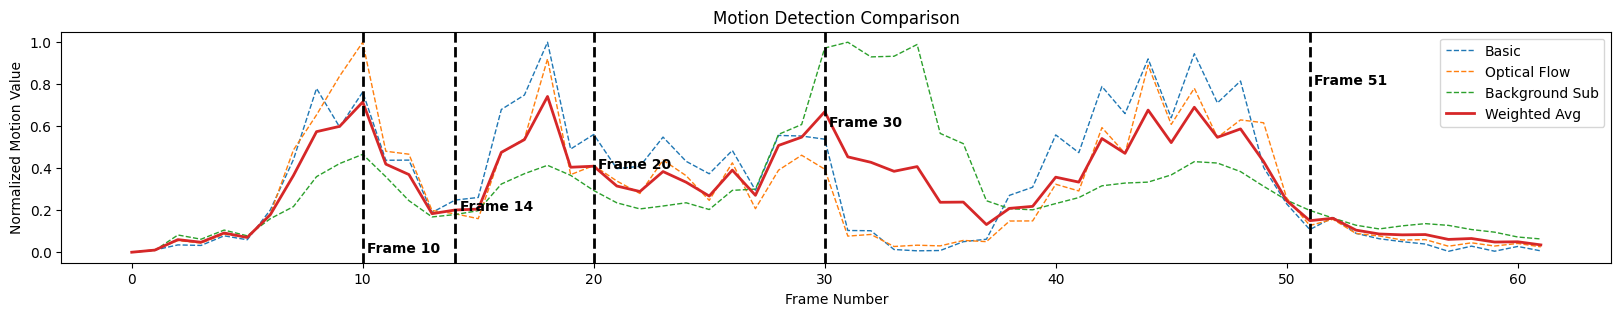

In [182]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic_normalized, mm_optical_flow_normalized, mm_background_subtraction_normalized, mm_combined_normalized])

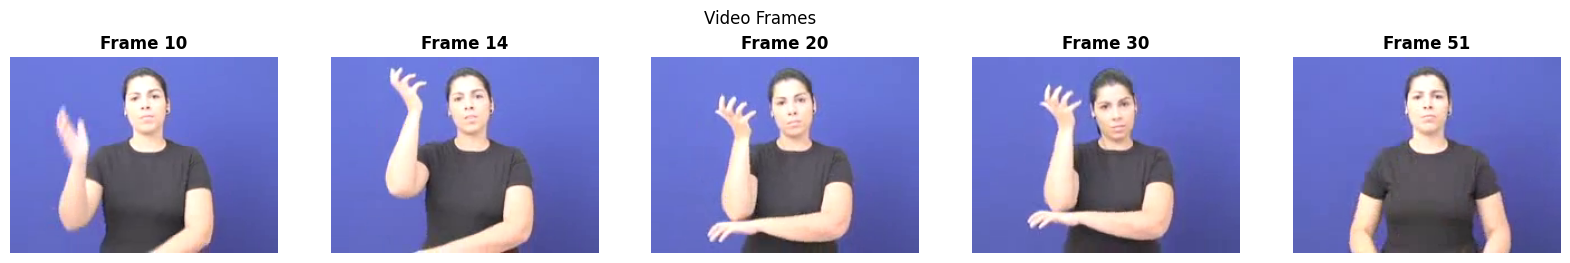

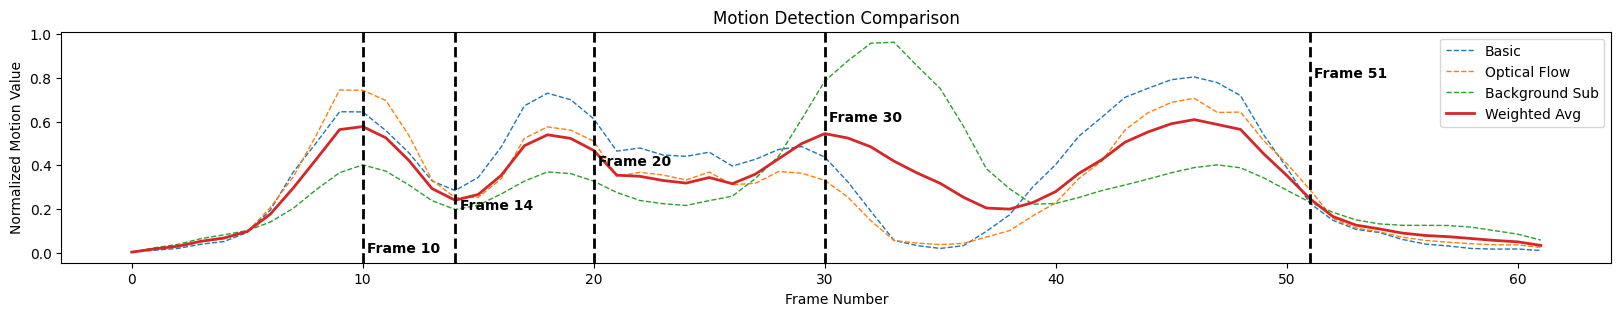

In [183]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_optical_flow, mm_background_subtraction, mm_combined])

#### Multiple Frames - Multiple Motion Measurement Plots

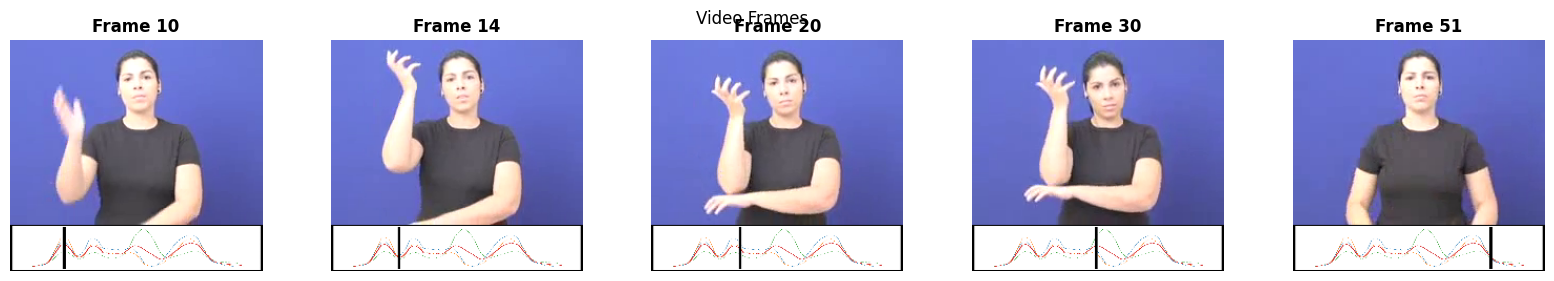

In [184]:
md.show_multiple_frames_multiple_plots(path, frame_numbers, [mm_basic, mm_optical_flow, mm_background_subtraction, mm_combined])

## Motion Analysis

### Simple Method - find the first and last frame above a set threshold value

#### INES

In [340]:
i = 0
row = video_metadata_df.iloc[i]
path = f"{path_to_root}data/raw/combined/videos/{row.filename}"
fps = row.fps
path, fps

('/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_ne_1.mp4',
 12.0)

In [341]:
weights = [0.5, 0.5]
window_duration = 0.334 #in seconds

In [342]:
# Measure basic motion
start_time = time.time()
mm_basic = md.moving_average(md.normalize_list_of_data(md.measure_motion_basic(path)), fps, window_duration=window_duration)
basic_time = time.time() - start_time
print(f"Basic motion detection took {basic_time:.2f} seconds")

# Measure background subtraction
start_time = time.time()
mm_bg_sub = md.moving_average(md.normalize_list_of_data(md.measure_motion_background_subtraction(path)), fps, window_duration=window_duration)
background_time = time.time() - start_time
print(f"Background subtraction method took {background_time:.2f} seconds")

# Combine with a weighted average
mm_combined = md.weighted_average_motion(
    [mm_basic, mm_bg_sub,],
    weights = [0.5, 0.5],
    )

print(F"\nTotal processing time: {basic_time + background_time:.2f} seconds")

window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
Basic motion detection took 0.02 seconds
window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
Background subtraction method took 0.07 seconds

Total processing time: 0.09 seconds


In [343]:
start_frame, end_frame = md.find_motion_boundaries_simple(
    mm_combined,
    start_threshold=0.2,
    end_threshold=0.2
)
start_frame, end_frame

(6, 36)

In [344]:
frame_numbers = [start_frame-1, start_frame, start_frame+1, start_frame+2, end_frame-2, end_frame-1, end_frame, end_frame+1]

# print the value in mm_combined for all the frames in frame_numbers, in one line
print([f" frame {frame_numbers[i]}: {round(mm_combined[frame_numbers[i]], 3)}" for i in range(len(frame_numbers))])

[' frame 5: 0.13', ' frame 6: 0.223', ' frame 7: 0.372', ' frame 8: 0.538', ' frame 34: 0.449', ' frame 35: 0.334', ' frame 36: 0.25', ' frame 37: 0.198']


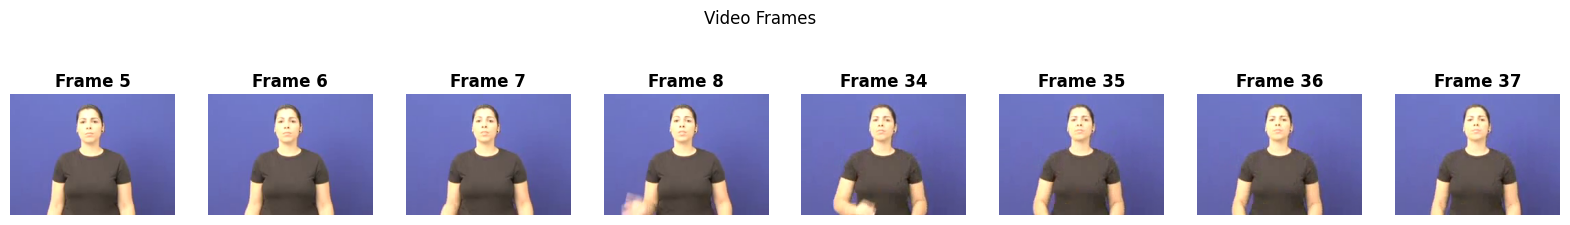

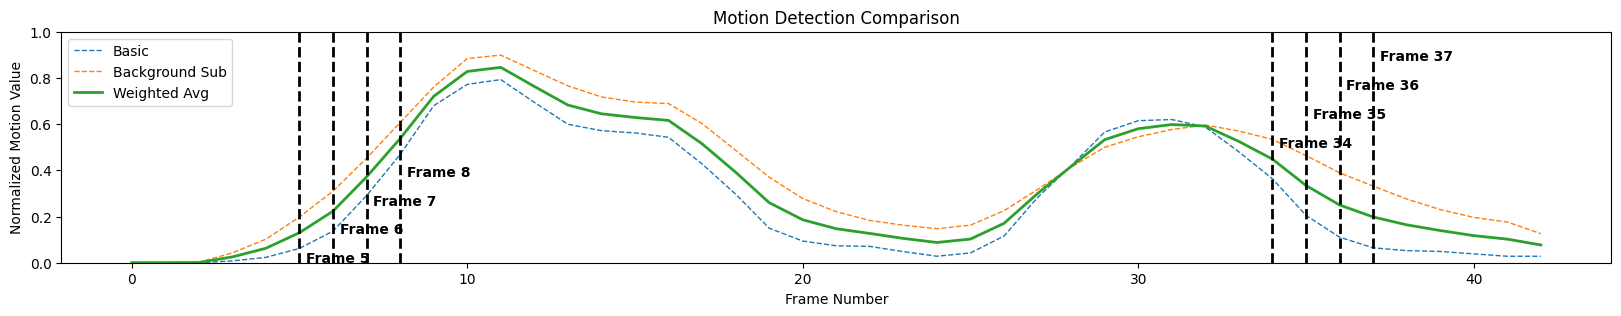

In [345]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_bg_sub, mm_combined])

Start slope peak: 8
End slope peak: 34
Start frame: 7
End frame: 35


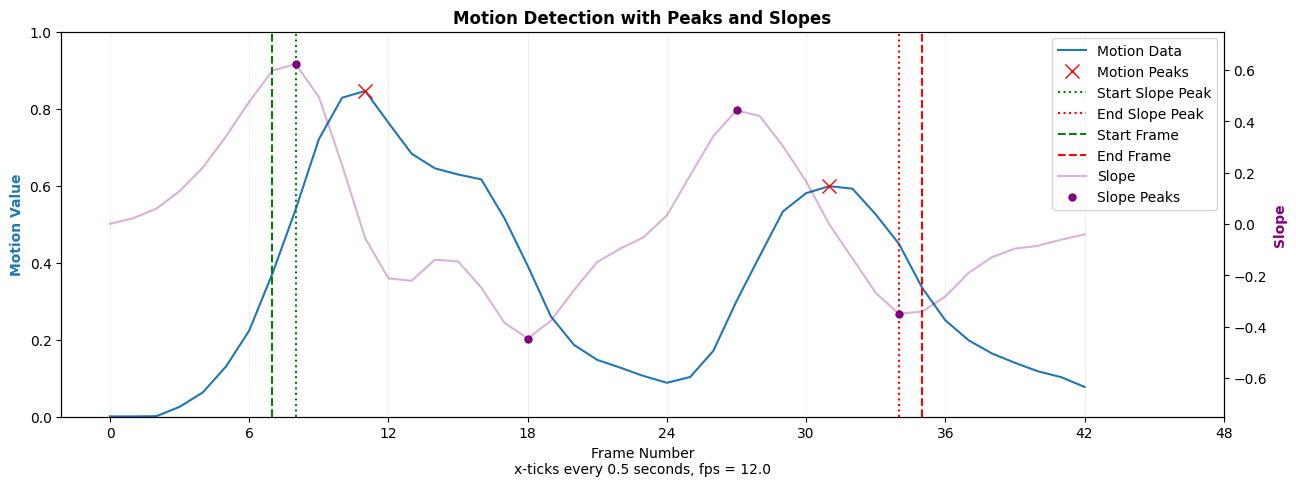

In [347]:
results = md.plot_motion_with_peaks_and_slopes(
    motion_data=mm_combined,
    fps=row.fps,
    min_motion_peak_height=0.4,
    min_motion_peak_width_seconds=.2,  # 0.2 seconds = 6 frames at 30fps
    min_slope_peak_height=0.1,
    min_slope_peak_width_seconds=0.2,
    start_buffer_seconds=0.15,
    end_buffer_seconds=0.15,
)

print(f"Start slope peak: {results['start_slope_peak']}")
print(f"End slope peak: {results['end_slope_peak']}")
print(f"Start frame: {results['start_frame']}")
print(f"End frame: {results['end_frame']}")

#### SignBank

In [300]:
i = 1
row = video_metadata_df.iloc[i]
path = f"{path_to_root}data/raw/combined/videos/{row.filename}"
lms_path = f"{path_to_root}data/interim/RawPoseLandmarks/{landmarks_version}/{row.filename.replace('.mp4', '.npy')}"
fps = row.fps
path, fps

('/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_sb_2.mp4',
 29.97002997002997)

In [301]:
weights = [0.5, 0.5]
window_duration = 0.334 #in seconds

In [302]:
# Measure basic motion
mm_basic = md.moving_average(md.normalize_list_of_data(md.measure_motion_basic(path)), fps, window_duration=window_duration)
# Measure background subtraction
mm_bg_sub = md.moving_average(md.normalize_list_of_data(md.measure_motion_background_subtraction(path)), fps, window_duration=window_duration)
# Measure lms difference
mm_lms = md.moving_average(md.normalize_list_of_data(md.measure_landmark_change(lms_path, use_pose=True, use_face=False, use_hands=True, combination_method='mean')), fps, window_duration=window_duration)

# Combine with a weighted average
mm_combined = md.weighted_average_motion(
    [mm_basic, mm_bg_sub, mm_lms],
    weights = [0.3, 0.3, 0.4],
    )

window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size


In [303]:
start_frame, end_frame = md.find_motion_boundaries_simple(
    mm_combined,
    start_threshold=0.2,
    end_threshold=0.2
)
start_frame, end_frame

(7, 67)

In [304]:
frame_numbers = [start_frame - 2 , start_frame, start_frame+3, start_frame+6, end_frame-6, end_frame-3, end_frame, end_frame+2]

# print the value in mm_combined for all the frames in frame_numbers, in one line
print([f" frame {frame_numbers[i]}: {round(mm_combined[frame_numbers[i]], 3)}" for i in range(len(frame_numbers))])

[' frame 5: 0.108', ' frame 7: 0.241', ' frame 10: 0.517', ' frame 13: 0.716', ' frame 61: 0.497', ' frame 64: 0.347', ' frame 67: 0.218', ' frame 69: 0.16']


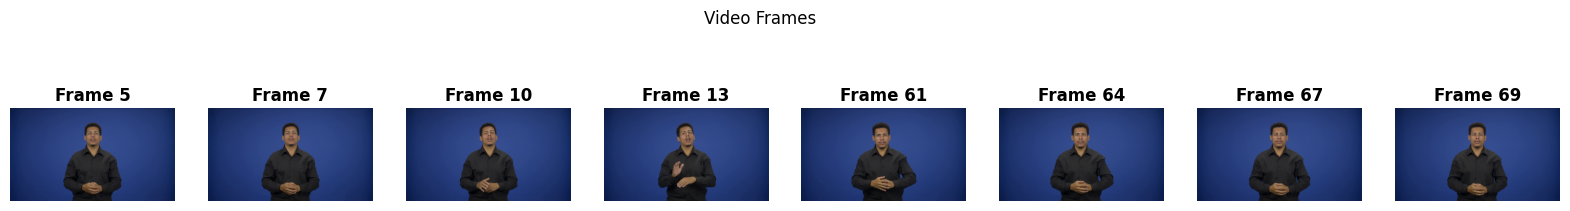

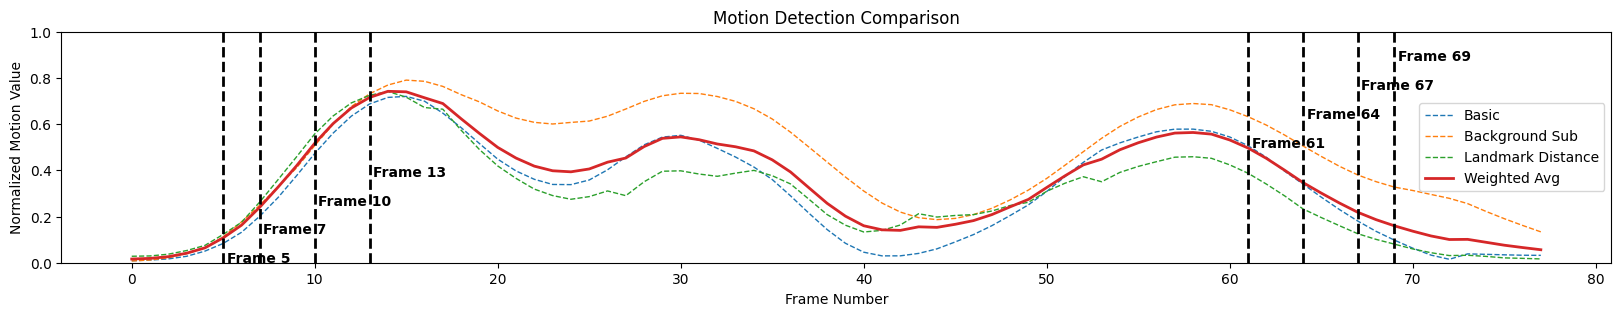

In [305]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_bg_sub, mm_lms, mm_combined])

Start slope peak: 9
End slope peak: 63
Start frame: 4
End frame: 68


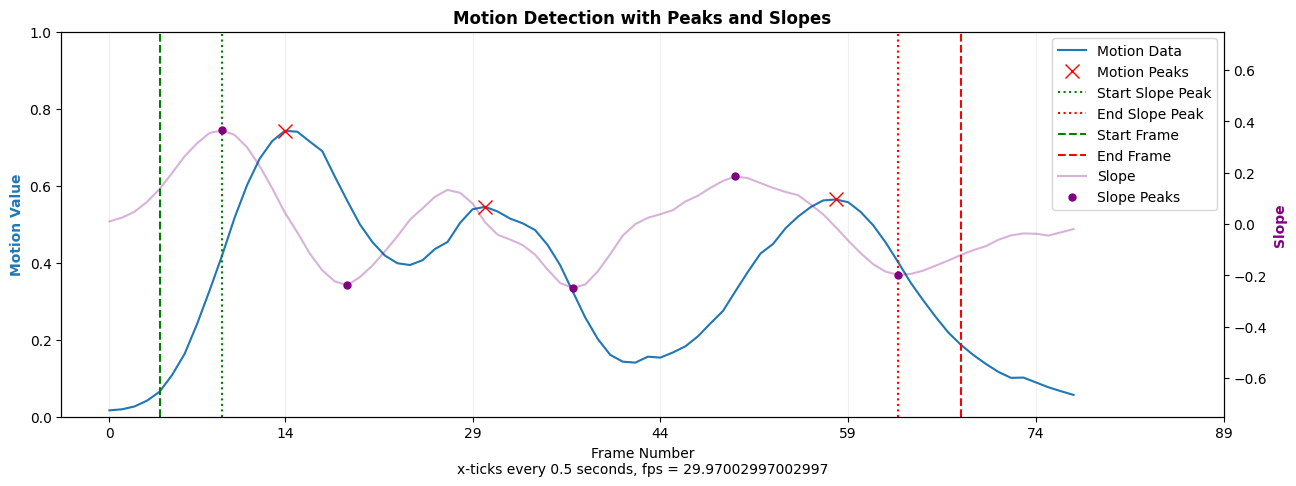

In [308]:
results = md.plot_motion_with_peaks_and_slopes(
    motion_data=mm_combined,
    fps=row.fps,
    min_motion_peak_height=0.4,
    min_motion_peak_width_seconds=.2,  # 0.2 seconds = 6 frames at 30fps
    min_slope_peak_height=0.1,
    min_slope_peak_width_seconds=0.2,
    start_buffer_seconds=0.2,
    end_buffer_seconds=0.2,
)

print(f"Start slope peak: {results['start_slope_peak']}")
print(f"End slope peak: {results['end_slope_peak']}")
print(f"Start frame: {results['start_frame']}")
print(f"End frame: {results['end_frame']}")

#### V-Librasil

In [309]:
i = 2
row = video_metadata_df.iloc[i]
path = f"{path_to_root}data/raw/combined/videos/{row.filename}"
lms_path = f"{path_to_root}data/interim/RawPoseLandmarks/{landmarks_version}/{row.filename.replace('.mp4', '.npy')}"
fps = row.fps
path, fps

('/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_uf_3.mp4',
 29.97002997002997)

In [310]:
weights = [0.5, 0.5]
window_duration = 0.334 #in seconds

In [311]:
# Measure basic motion
mm_basic = md.moving_average(md.normalize_list_of_data(md.measure_motion_basic(path)), fps, window_duration=window_duration)
# Measure background subtraction
mm_bg_sub = md.moving_average(md.normalize_list_of_data(md.measure_motion_background_subtraction(path)), fps, window_duration=window_duration)
# Measure lms difference
mm_lms = md.moving_average(md.normalize_list_of_data(md.measure_landmark_change(lms_path, use_pose=True, use_face=False, use_hands=True, combination_method='mean')), fps, window_duration=window_duration)

# Combine with a weighted average
mm_combined = md.weighted_average_motion(
    [mm_basic, mm_bg_sub, mm_lms],
    weights = [0.3, 0.3, 0.4],
    )

window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size


window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size


In [312]:
start_frame, end_frame = md.find_motion_boundaries_simple(
    mm_combined,
    start_threshold=0.3,
    end_threshold=0.3,
)
start_frame, end_frame

(25, 88)

In [313]:
frame_numbers = [start_frame - 2 , start_frame, start_frame+3, start_frame+6, end_frame-6, end_frame-3, end_frame, end_frame+2]

# print the value in mm_combined for all the frames in frame_numbers, in one line
print([f" frame {frame_numbers[i]}: {round(mm_combined[frame_numbers[i]], 3)}" for i in range(len(frame_numbers))])

[' frame 23: 0.156', ' frame 25: 0.309', ' frame 28: 0.571', ' frame 31: 0.696', ' frame 82: 0.521', ' frame 85: 0.441', ' frame 88: 0.327', ' frame 90: 0.258']


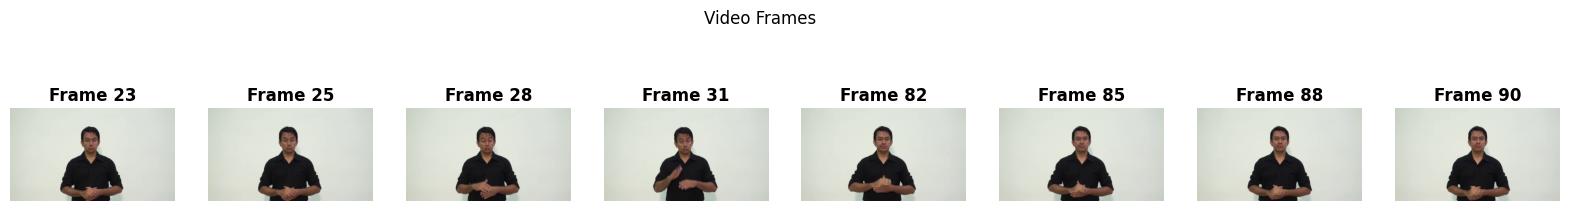

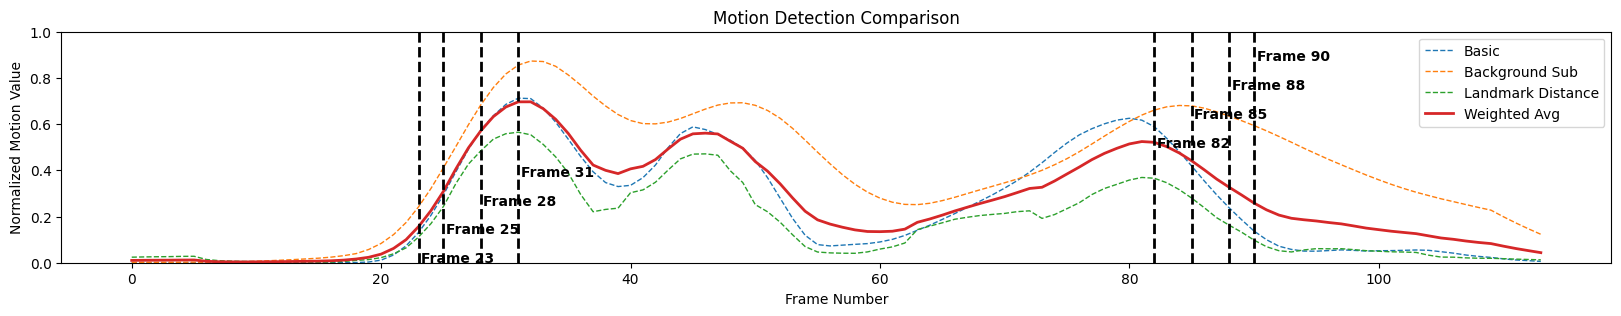

In [314]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_bg_sub, mm_lms, mm_combined])

Start slope peak: 26
End slope peak: 86
Start frame: 22
End frame: 90


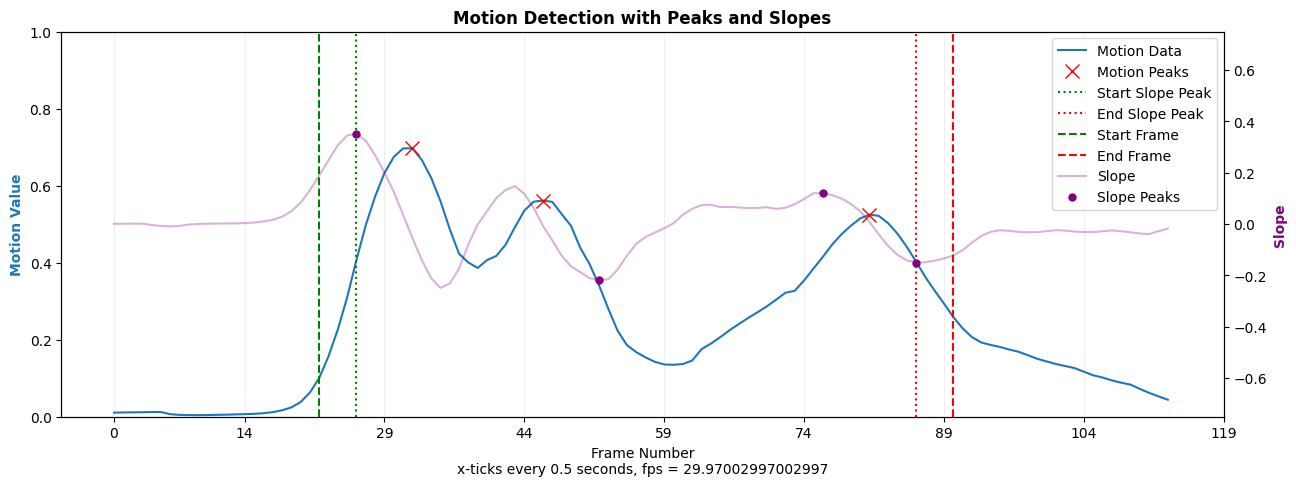

In [316]:
results = md.plot_motion_with_peaks_and_slopes(
    motion_data=mm_combined,
    fps=row.fps,
    min_motion_peak_height=0.4,
    min_motion_peak_width_seconds=.2,  # 0.2 seconds = 6 frames at 30fps
    min_slope_peak_height=0.1,
    min_slope_peak_width_seconds=0.2,
    start_buffer_seconds=0.15,
    end_buffer_seconds=0.15,
)

print(f"Start slope peak: {results['start_slope_peak']}")
print(f"End slope peak: {results['end_slope_peak']}")
print(f"Start frame: {results['start_frame']}")
print(f"End frame: {results['end_frame']}")

#### UFV

In [317]:
i = 5
row = video_metadata_df.iloc[i]
path = f"{path_to_root}data/raw/combined/videos/{row.filename}"
lms_path = f"{path_to_root}data/interim/RawPoseLandmarks/{landmarks_version}/{row.filename.replace('.mp4', '.npy')}"
fps = row.fps
path, fps

('/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_vl_6.mp4',
 60.0)

In [318]:
weights = [0.5, 0.5]
window_duration = 0.334 #in seconds

In [319]:
# Measure basic motion
mm_basic = md.moving_average(md.normalize_list_of_data(md.measure_motion_basic(path)), fps, window_duration=window_duration)
# Measure background subtraction
mm_bg_sub = md.moving_average(md.normalize_list_of_data(md.measure_motion_background_subtraction(path)), fps, window_duration=window_duration)
# Measure lms difference
mm_lms = md.moving_average(md.normalize_list_of_data(md.measure_landmark_change(lms_path, use_pose=True, use_face=False, use_hands=True, combination_method='mean')), fps, window_duration=window_duration)

# Combine with a weighted average
mm_combined = md.weighted_average_motion(
    [mm_basic, mm_bg_sub, mm_lms],
    weights = [0.3, 0.3, 0.4],
    )

window_duration: 0.334 seconds, at 60.0 fps = 20 frame window_size
window_duration: 0.334 seconds, at 60.0 fps = 20 frame window_size
window_duration: 0.334 seconds, at 60.0 fps = 20 frame window_size


In [320]:
start_frame, end_frame = md.find_motion_boundaries_simple(
    mm_combined,
    start_threshold=0.3,
    end_threshold=0.3,
)
start_frame, end_frame

(7, 257)

In [321]:
frame_numbers = [start_frame - 2 , start_frame, start_frame+3, start_frame+6, end_frame-6, end_frame-3, end_frame, end_frame+2]

# print the value in mm_combined for all the frames in frame_numbers, in one line
print([f" frame {frame_numbers[i]}: {round(mm_combined[frame_numbers[i]], 3)}" for i in range(len(frame_numbers))])

[' frame 5: 0.271', ' frame 7: 0.317', ' frame 10: 0.403', ' frame 13: 0.482', ' frame 251: 0.307', ' frame 254: 0.299', ' frame 257: 0.3', ' frame 259: 0.282']


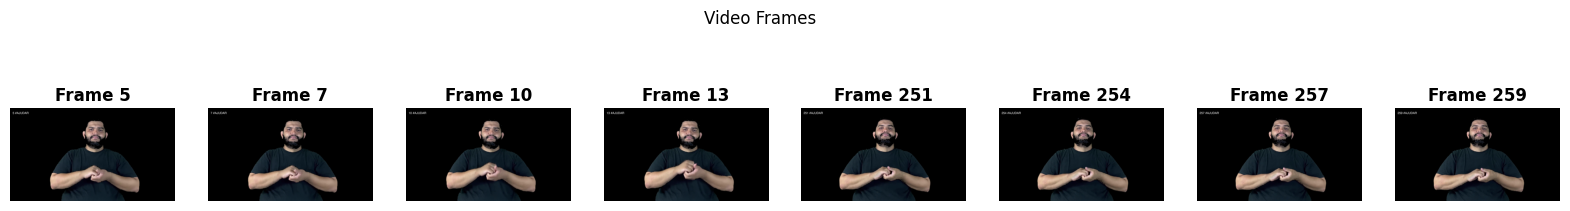

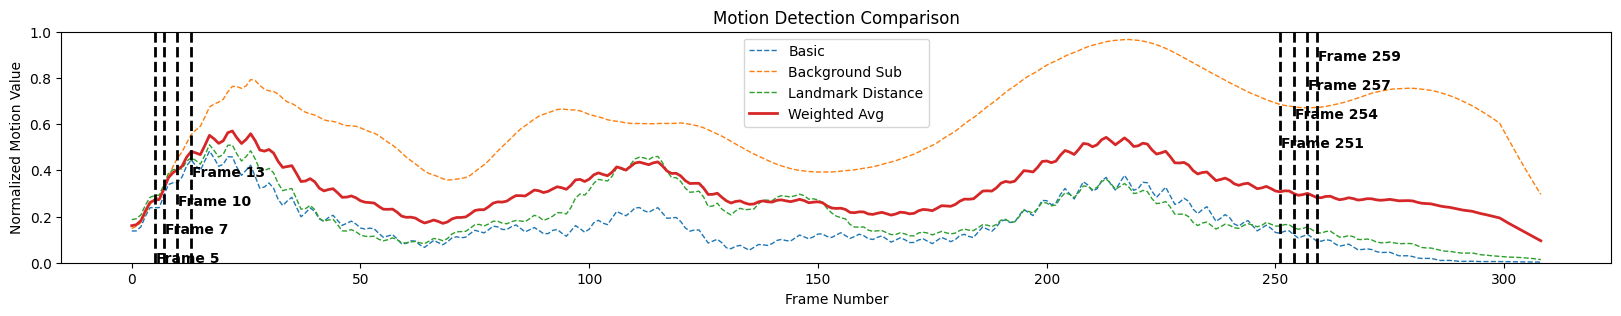

In [322]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_bg_sub, mm_lms, mm_combined])

No slope peaks found, falling back to simple threshold method
Start slope peak: 22
End slope peak: 213
Start frame: 7
End frame: 257


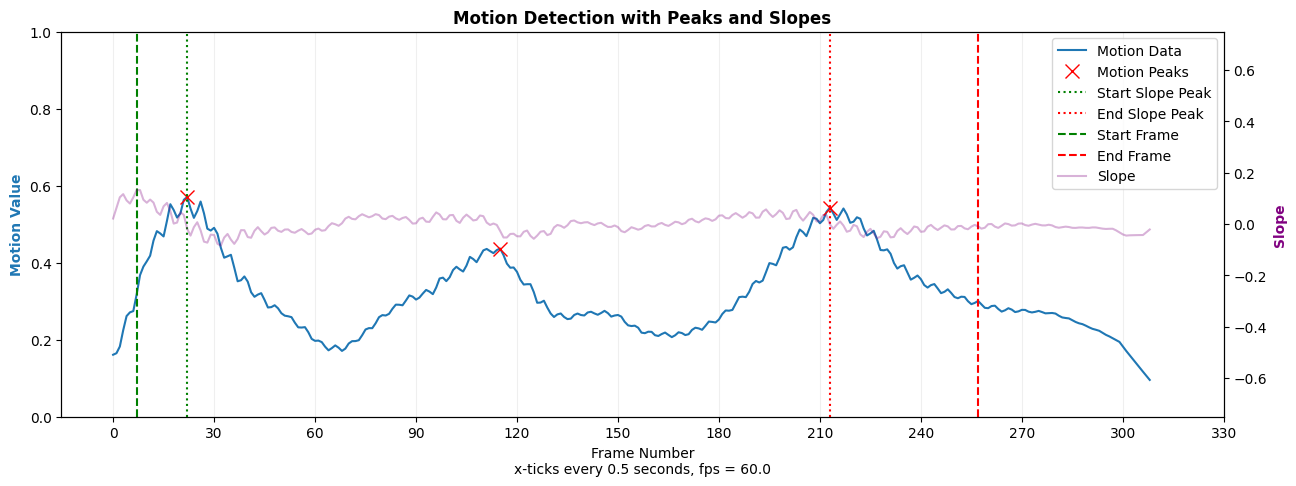

In [339]:
results = md.plot_motion_with_peaks_and_slopes(
    motion_data=mm_combined,
    fps=row.fps,
    # min_motion_peak_height=0.4,
    # min_motion_peak_width_seconds=.1,  # 0.2 seconds = 6 frames at 30fps
    # min_slope_peak_height=0.1,
    # min_slope_peak_width_seconds=0.1,
    # start_buffer_seconds=0.15,
    # end_buffer_seconds=0.15,
    # slope_window_size=5,
    min_motion_peak_height=0.4,
    min_motion_peak_width_seconds=.2,  # 0.2 seconds = 6 frames at 30fps
    min_slope_peak_height=0.1,
    min_slope_peak_width_seconds=0.2,
    start_buffer_seconds=0.15,
    end_buffer_seconds=0.15,
)

print(f"Start slope peak: {results['start_slope_peak']}")
print(f"End slope peak: {results['end_slope_peak']}")
print(f"Start frame: {results['start_frame']}")
print(f"End frame: {results['end_frame']}")

### Peaks Method

In [ ]:
# Example usage
fps = 30  # Your video's FPS
start_frame, end_frame = find_motion_boundaries_peaks(
    motion_data=normalized_motion_data,
    fps=fps,
    min_peak_height=0.2,  # Adjust based on your motion data
    min_peak_distance_seconds=0.5,  # Minimum time between peaks
    look_around_duration=0.2  # How far to look before/after peaks
)

## Experiment on a bunch

### Explore a range of thresholds & Methods

#### Run threshold experiments

In [356]:
two_c_dict = {
    'filename': [],
    'window_duration': [],
    'data_source': [],
    'fps': [],
    'frame_count': [],
    'duration': [],
    'threshold': [],
    'start_frame': [],
    'end_frame': [],
    'peak_start_frame': [],
    'peak_end_frame': [],
    'fallback_bool': [],
}
three_c_dict = {
    'filename': [],
    'window_duration': [],
    'data_source': [],
    'fps': [],
    'frame_count': [],
    'duration': [],
    'threshold': [],
    'start_frame': [],
    'end_frame': [],
    'peak_start_frame': [],
    'peak_end_frame': [],
    'fallback_bool': [],
}
lms_dict = {
    'filename': [],
    'window_duration': [],
    'data_source': [],
    'fps': [],
    'frame_count': [],
    'duration': [],
    'threshold': [],
    'start_frame': [],
    'end_frame': [],
    'peak_start_frame': [],
    'peak_end_frame': [],   
    'fallback_bool': [],
}

for i, row in video_metadata_df.iterrows():
    print(f"Processing {i}")
    path = f"{path_to_root}data/raw/combined/videos/{row.filename}"
    lms_path = f"{path_to_root}data/interim/RawPoseLandmarks/{landmarks_version}/{row.filename.replace('.mp4', '.npy')}"
    data_source = row.data_source
    fps = row.fps
    frame_count = row.frame_count
    duration = row.duration_sec
    window_duration = 0.334 #in seconds
    
    mm_basic = md.normalize_list_of_data(md.moving_average(md.measure_motion_basic(path), fps, window_duration=window_duration, verbose=False))
    # Measure background subtraction
    mm_bg_sub = md.normalize_list_of_data(md.moving_average(md.measure_motion_background_subtraction(path), fps, window_duration=window_duration, verbose=False))
    # Measure lms difference        
    mm_lms = md.normalize_list_of_data(md.moving_average(md.measure_landmark_change(lms_path, use_pose=True, use_face=False, use_hands=True, combination_method='rms'), fps, window_duration=window_duration, verbose=False))
    
    # Combine with a weighted average
    two_combined = md.normalize_list_of_data(md.weighted_average_motion(
        [mm_basic, mm_bg_sub],
        weights = [0.5, 0.5],
        )
    )
    three_combined = md.normalize_list_of_data(md.weighted_average_motion(
        [mm_basic, mm_bg_sub, mm_lms],
        weights = [0.3, 0.3, 0.4],
        )
    )
    
    two_combined_thresholds = [0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34]
    three_combined_thresholds = [0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34]
    lms_thresholds = [0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34]
    
    for threshold in two_combined_thresholds:
        start_frame, end_frame = md.find_motion_boundaries_simple(two_combined, threshold)
        peaks_results = md.find_motion_boundaries_peaks(two_combined, fps,
                                                                           start_buffer_seconds=0, 
                                                                           end_buffer_seconds=0,
                                                                           fallback_simple_start_threshold=threshold,
                                                                           fallback_simple_end_threshold=threshold)

        two_c_dict['filename'].append(row.filename)
        two_c_dict['window_duration'].append(window_duration)
        two_c_dict['data_source'].append(data_source)
        two_c_dict['fps'].append(fps)
        two_c_dict['frame_count'].append(frame_count)
        two_c_dict['duration'].append(duration)
        two_c_dict['threshold'].append(threshold)
        two_c_dict['start_frame'].append(start_frame)
        two_c_dict['end_frame'].append(end_frame)
        two_c_dict['peak_start_frame'].append(peaks_results[0])
        two_c_dict['peak_end_frame'].append(peaks_results[1])
        two_c_dict['fallback_bool'].append(peaks_results[6])
    for threshold in three_combined_thresholds:
        start_frame, end_frame = md.find_motion_boundaries_simple(three_combined, threshold)
        peaks_results = md.find_motion_boundaries_peaks(three_combined, fps,
                                                                           start_buffer_seconds=0, 
                                                                           end_buffer_seconds=0,
                                                                           fallback_simple_start_threshold=threshold,
                                                                           fallback_simple_end_threshold=threshold)

        three_c_dict['filename'].append(row.filename)
        three_c_dict['window_duration'].append(window_duration)
        three_c_dict['data_source'].append(data_source)
        three_c_dict['fps'].append(fps)
        three_c_dict['frame_count'].append(frame_count)
        three_c_dict['duration'].append(duration)
        three_c_dict['threshold'].append(threshold)
        three_c_dict['start_frame'].append(start_frame)
        three_c_dict['end_frame'].append(end_frame)
        three_c_dict['peak_start_frame'].append(peaks_results[0])
        three_c_dict['peak_end_frame'].append(peaks_results[1])
        three_c_dict['fallback_bool'].append(peaks_results[6])
    for threshold in lms_thresholds:
        start_frame, end_frame = md.find_motion_boundaries_simple(mm_lms, threshold)
        peaks_results = md.find_motion_boundaries_peaks(mm_lms, fps,
                                                                           start_buffer_seconds=0, 
                                                                           end_buffer_seconds=0,
                                                                           fallback_simple_start_threshold=threshold,
                                                                           fallback_simple_end_threshold=threshold)

        lms_dict['filename'].append(row.filename)
        lms_dict['window_duration'].append(window_duration) 
        lms_dict['data_source'].append(data_source)
        lms_dict['fps'].append(fps)
        lms_dict['frame_count'].append(frame_count)
        lms_dict['duration'].append(duration)
        lms_dict['threshold'].append(threshold)
        lms_dict['start_frame'].append(start_frame)
        lms_dict['end_frame'].append(end_frame)
        lms_dict['peak_start_frame'].append(peaks_results[0])
        lms_dict['peak_end_frame'].append(peaks_results[1])
        lms_dict['fallback_bool'].append(peaks_results[6])

Processing 0
Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold method
No slope peaks found, falling back to simple threshold

In [381]:
def add_start_end_info(df):
    df['start_time'] = df['start_frame'] / df['fps']
    df['end_time'] = df['end_frame'] / df['fps']
    df['start_percent'] = df['start_frame'] / df['frame_count']
    df['end_percent'] = df['end_frame'] / df['frame_count']
    df['new_frame_count'] = df['end_frame'] - df['start_frame']
    df['new_duration_sec'] = df['new_frame_count'] / df['fps']
    df['new_duration_percent'] = df['new_frame_count'] / df['frame_count']
    df['peak_start_percent'] = df['peak_start_frame'] / df['frame_count']
    df['peak_end_percent'] = df['peak_end_frame'] / df['frame_count']
    return df

In [382]:
two_c_df = add_start_end_info(pd.DataFrame(two_c_dict))
three_c_df = add_start_end_info(pd.DataFrame(three_c_dict))
lms_df = add_start_end_info(pd.DataFrame(lms_dict))

In [383]:
two_c_df.to_csv(f"{path_to_root}data/interim/motion_two_c_df.csv", index=False)
three_c_df.to_csv(f"{path_to_root}data/interim/motion_three_c_df.csv", index=False)
lms_df.to_csv(f"{path_to_root}data/interim/motion_lms_df.csv", index=False)

#### Load previous threshold experiments

In [384]:
two_c_df = pd.read_csv(f"{path_to_root}data/interim/motion_two_c_df.csv")
three_c_df = pd.read_csv(f"{path_to_root}data/interim/motion_three_c_df.csv") 
lms_df = pd.read_csv(f"{path_to_root}data/interim/motion_lms_df.csv")

In [452]:
lms_df.loc[lms_df['filename'] == 'ajudar_sb_2.mp4']

filename  window_duration data_source       fps  frame_count  \
10  ajudar_sb_2.mp4            0.334          sb  29.97003           79   
11  ajudar_sb_2.mp4            0.334          sb  29.97003           79   
12  ajudar_sb_2.mp4            0.334          sb  29.97003           79   
13  ajudar_sb_2.mp4            0.334          sb  29.97003           79   
14  ajudar_sb_2.mp4            0.334          sb  29.97003           79   
15  ajudar_sb_2.mp4            0.334          sb  29.97003           79   
16  ajudar_sb_2.mp4            0.334          sb  29.97003           79   
17  ajudar_sb_2.mp4            0.334          sb  29.97003           79   
18  ajudar_sb_2.mp4            0.334          sb  29.97003           79   
19  ajudar_sb_2.mp4            0.334          sb  29.97003           79   

    duration  threshold  start_frame  end_frame  peak_start_frame  ...  \
10  2.635967       0.16            5         66                 8  ...   
11  2.635967       0.18            5         66                 8  ...   
12  2.635967       0.20            6         65                 8  ...   
13  2.635967       0.22            6         65                 8  ...   
14  2.635967       0.24            6         64                 8  ...   
15  2.635967       0.26            7         64                 8  ...   
16  2.635967       0.28            7         63                 8  ...   
17  2.635967       0.30            7         63                 8  ...   
18  2.635967       0.32            7         63                 8  ...   
19  2.635967       0.34            7         63                 8  ...   

    fallback_bool  start_time  end_time  start_percent  end_percent  \
10          False    0.166833  2.202200       0.063291     0.835443   
11          False    0.166833  2.202200       0.063291     0.835443   
12          False    0.200200  2.168833       0.075949     0.822785   
13          False    0.200200  2.168833       0.075949     0.822785   
14          False    0.200200  2.135467       0.075949     0.810127   
15          False    0.233567  2.135467       0.088608     0.810127   
16          False    0.233567  2.102100       0.088608     0.797468   
17          False    0.233567  2.102100       0.088608     0.797468   
18          False    0.233567  2.102100       0.088608     0.797468   
19          False    0.233567  2.102100       0.088608     0.797468   

    new_frame_count  new_duration_sec  new_duration_percent  \
10               61          2.035367              0.772152   
11               61          2.035367              0.772152   
12               59          1.968633              0.746835   
13               59          1.968633              0.746835   
14               58          1.935267              0.734177   
15               57          1.901900              0.721519   
16               56          1.868533              0.708861   
17               56          1.868533              0.708861   
18               56          1.868533              0.708861   
19               56          1.868533              0.708861   

    peak_start_percent  peak_end_percent  
10            0.101266           0.78481  
11            0.101266           0.78481  
12            0.101266           0.78481  
13            0.101266           0.78481  
14            0.101266           0.78481  
15            0.101266           0.78481  
16            0.101266           0.78481  
17            0.101266           0.78481  
18            0.101266           0.78481  
19            0.101266           0.78481  

[10 rows x 21 columns]

In [386]:
two_c_df[two_c_df['fallback_bool'] == True].filename.unique(), three_c_df[three_c_df['fallback_bool'] == True].filename.unique(), lms_df[lms_df['fallback_bool'] == True].filename.unique(), 

(array(['ajudar_vl_6.mp4', 'vagina_vl_6.mp4'], dtype=object),
 array(['ajudar_vl_6.mp4', 'bebê_vl_6.mp4'], dtype=object),
 array(['ajudar_vl_6.mp4', 'aniversário_vl_4.mp4', 'ano_vl_6.mp4',
        'banheiro_vl_4.mp4', 'bebê_vl_5.mp4', 'bebê_vl_6.mp4',
        'carne_vl_6.mp4', 'comer_vl_6.mp4', 'garganta_vl_6.mp4',
        'homem_vl_6.mp4', 'jovem_vl_6.mp4', 'ouvir_vl_5.mp4',
        'pai_vl_4.mp4'], dtype=object))

<Axes: xlabel='start_percent', ylabel='Density'>

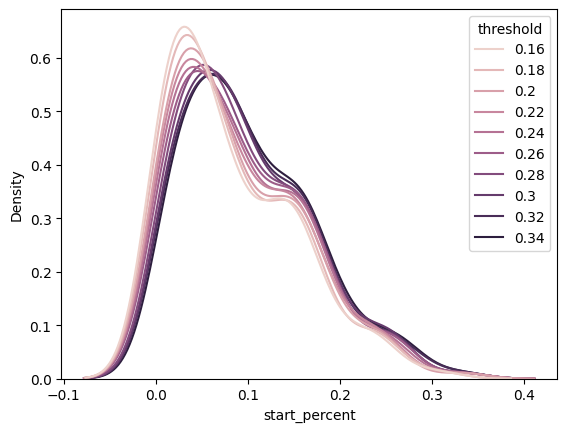

In [387]:
sns.kdeplot(data=three_c_df, x='start_percent', hue='threshold')

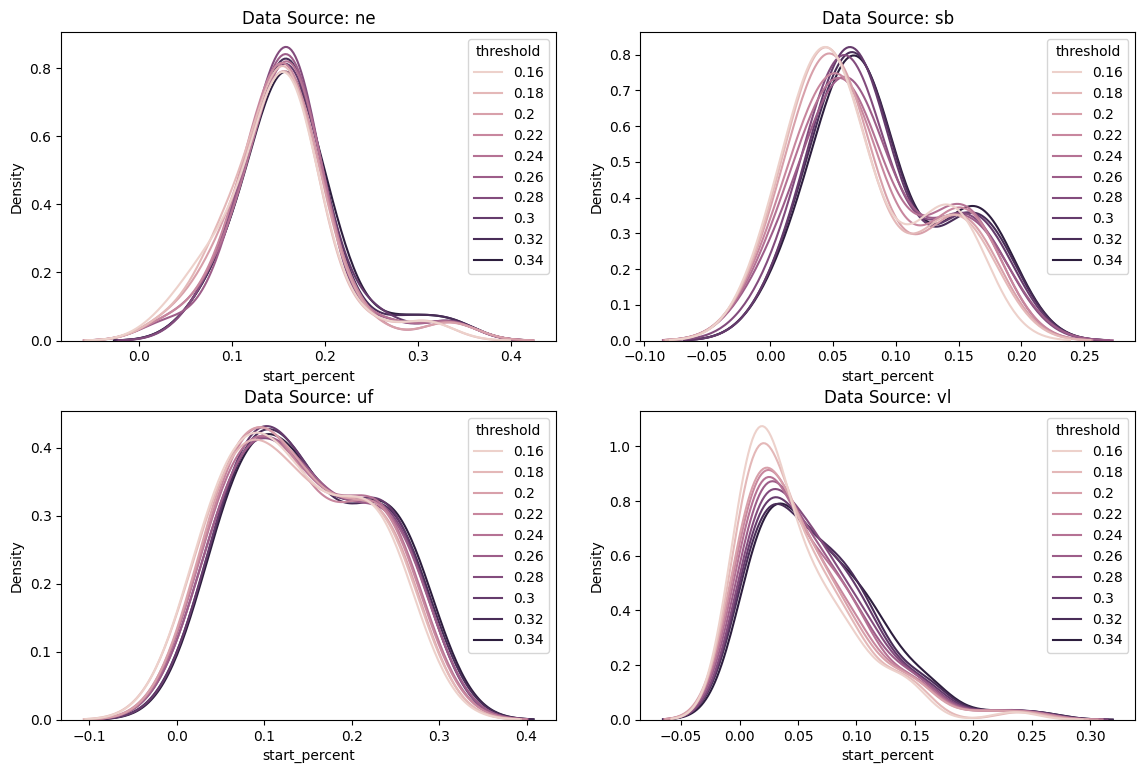

In [393]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.tight_layout(pad=3.0)

for i, source in enumerate(['ne', 'sb', 'uf', 'vl']):
    row = i // 2
    col = i % 2
    sns.kdeplot(data=three_c_df[three_c_df['data_source'] == source], 
                x='start_percent', 
                hue='threshold',
                ax=axes[row,col])
    axes[row,col].set_title(f'Data Source: {source}')

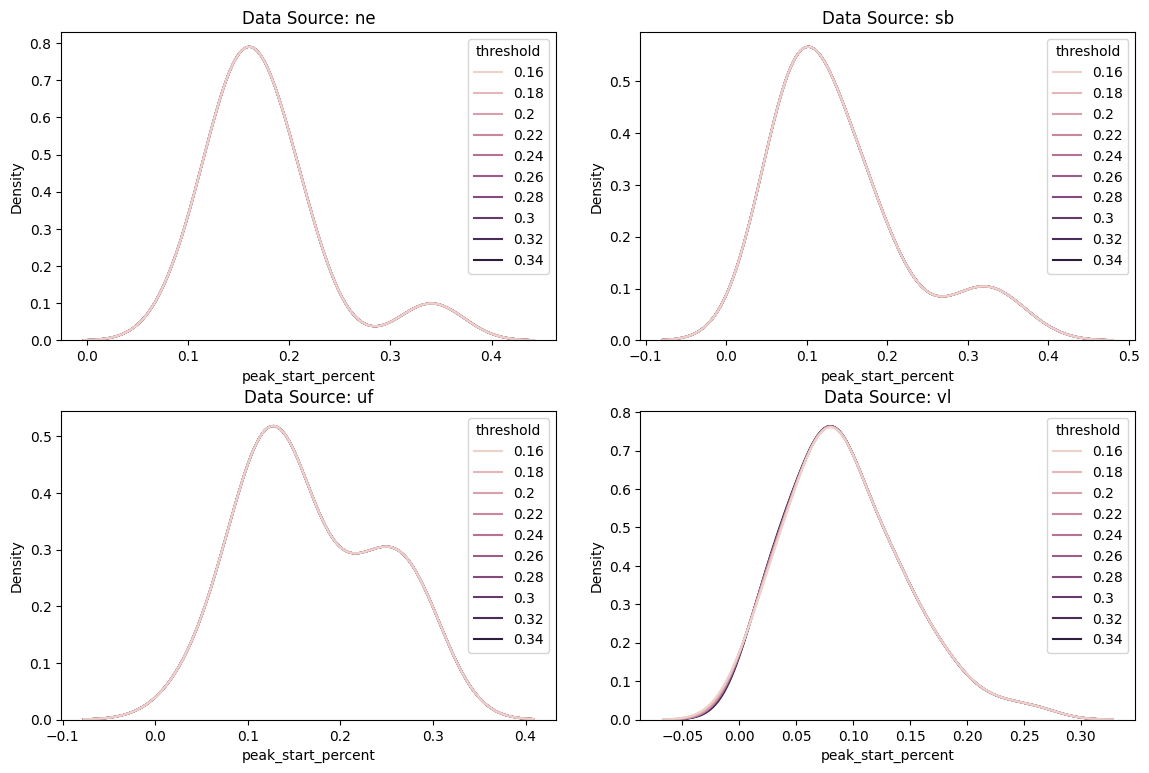

In [389]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.tight_layout(pad=3.0)

for i, source in enumerate(['ne', 'sb', 'uf', 'vl']):
    row = i // 2
    col = i % 2
    sns.kdeplot(data=three_c_df[three_c_df['data_source'] == source], 
                x='peak_start_percent', 
                hue='threshold',
                ax=axes[row,col])
    axes[row,col].set_title(f'Data Source: {source}')

In [395]:
two_c_grouped = two_c_df[['data_source', 'threshold', 'start_percent', 'end_percent', 'new_duration_percent']].groupby(by=['data_source', 'threshold']).mean()

In [396]:
three_c_grouped = three_c_df[['data_source', 'threshold', 'start_percent', 'end_percent', 'new_duration_percent']].groupby(by=['data_source', 'threshold']).mean()

In [397]:
lms_grouped = lms_df[['data_source', 'threshold', 'start_percent', 'end_percent', 'new_duration_percent']].groupby(by=['data_source', 'threshold']).mean()

In [398]:
lms_grouped

start_percent  end_percent  new_duration_percent
data_source threshold                                                  
ne          0.16            0.151661     0.802817              0.651156
            0.18            0.153400     0.798790              0.645390
            0.20            0.155262     0.796656              0.641395
            0.22            0.159263     0.795575              0.636312
            0.24            0.160367     0.794759              0.634391
            0.26            0.161343     0.793540              0.632197
            0.28            0.161343     0.790854              0.629511
            0.30            0.165771     0.789315              0.623543
            0.32            0.165771     0.784043              0.618272
            0.34            0.166461     0.781241              0.614780
sb          0.16            0.061779     0.893617              0.831838
            0.18            0.064853     0.889563              0.824710
            0.20            0.068240     0.887391              0.819151
            0.22            0.072320     0.882829              0.810509
            0.24            0.073331     0.878739              0.805408
            0.26            0.075206     0.875925              0.800719
            0.28            0.078712     0.872803              0.794091
            0.30            0.082302     0.869404              0.787102
            0.32            0.083421     0.865168              0.781747
            0.34            0.084416     0.857374              0.772958
uf          0.16            0.131833     0.813967              0.682134
            0.18            0.133373     0.805362              0.671989
            0.20            0.136675     0.800788              0.664112
            0.22            0.139302     0.798576              0.659273
            0.24            0.141389     0.794284              0.652895
            0.26            0.143216     0.792978              0.649762
            0.28            0.145797     0.789856              0.644059
            0.30            0.147606     0.786827              0.639222
            0.32            0.149793     0.784769              0.634976
            0.34            0.151430     0.781513              0.630083
vl          0.16            0.020974     0.930401              0.909427
            0.18            0.026499     0.920357              0.893858
            0.20            0.030881     0.909500              0.878619
            0.22            0.036673     0.900260              0.863587
            0.24            0.040351     0.895530              0.855179
            0.26            0.042334     0.885752              0.843417
            0.28            0.044530     0.874640              0.830110
            0.30            0.047289     0.870402              0.823113
            0.32            0.053602     0.859077              0.805475
            0.34            0.056051     0.851998              0.795947

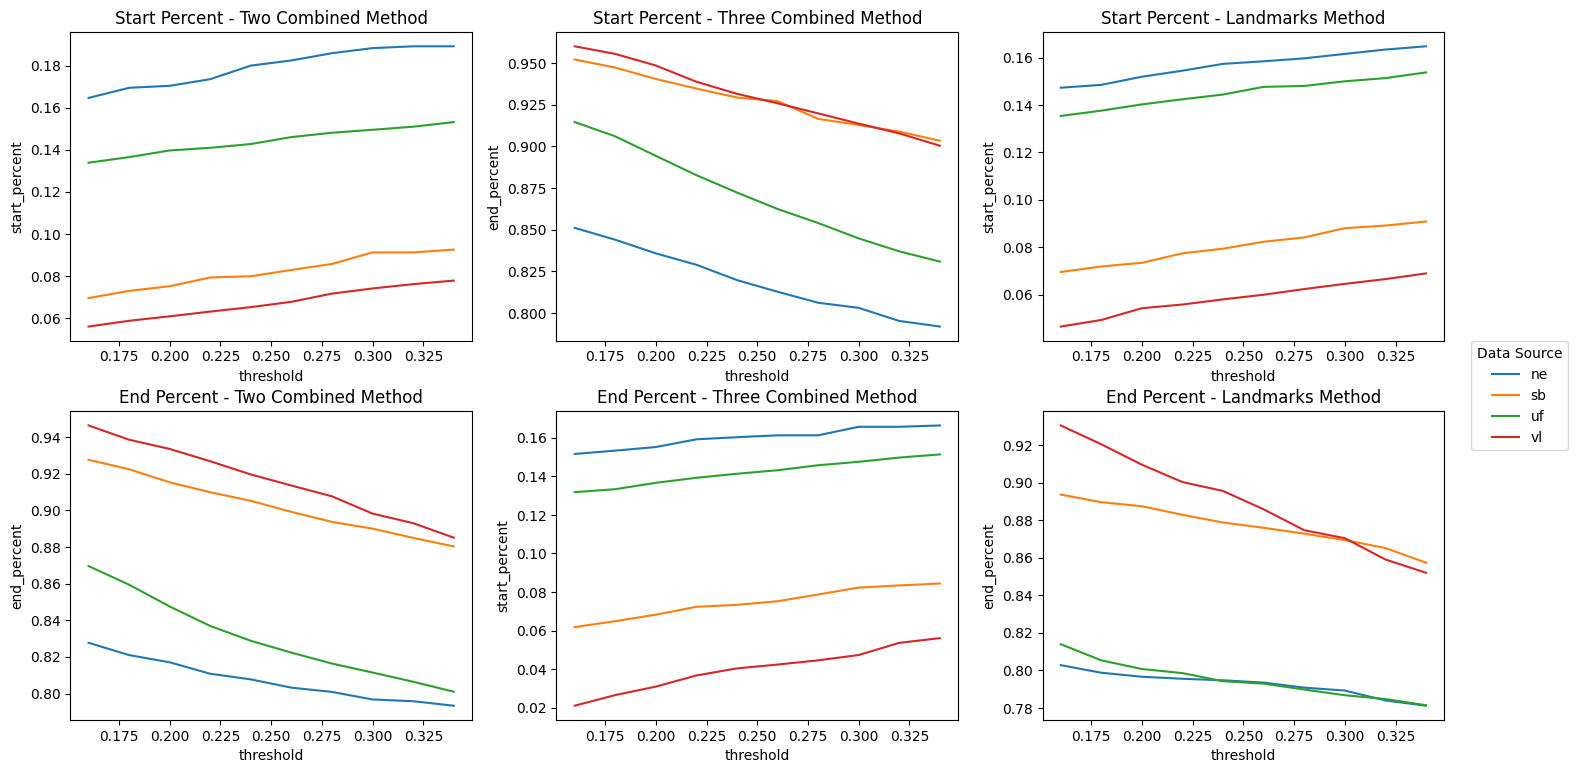

In [399]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plt.tight_layout(pad=3.0)

# Two Combined Method plots
sns.lineplot(data=two_c_grouped, x='threshold', y='start_percent', hue='data_source', ax=axes[0,0], legend=False)
axes[0,0].set_title('Start Percent - Two Combined Method')

sns.lineplot(data=two_c_grouped, x='threshold', y='end_percent', hue='data_source', ax=axes[0,1], legend=False)
axes[1,0].set_title('End Percent - Two Combined Method')

# Three Combined Method plots
sns.lineplot(data=three_c_grouped, x='threshold', y='start_percent', hue='data_source', ax=axes[0,2], legend=False)
axes[0,1].set_title('Start Percent - Three Combined Method')

sns.lineplot(data=three_c_grouped, x='threshold', y='end_percent', hue='data_source', ax=axes[1,0], legend=False)
axes[1,1].set_title('End Percent - Three Combined Method')

# Landmarks Method plots
sns.lineplot(data=lms_grouped, x='threshold', y='start_percent', hue='data_source', ax=axes[1,1], legend=False)
axes[0,2].set_title('Start Percent - Landmarks Method')

# Create single legend from last plot
lines = sns.lineplot(data=lms_grouped, x='threshold', y='end_percent', hue='data_source', ax=axes[1,2])
axes[1,2].set_title('End Percent - Landmarks Method')

# Move legend outside plots
plt.legend(bbox_to_anchor=(1.05, 1.25), loc='upper left', title='Data Source')

### Inspect One Threshold / Method [simple]

In [400]:
method = 'landmarks'
window_duration = 0.334 #in seconds
start_threshold = 0.2
end_threshold = 0.2



info_dict = {
    'filename': [],
    'window_duration': [],
    'data_source': [],
    'fps': [],
    'frame_count': [],
    'duration': [],
    'start_threshold': [],
    'end_threshold': [],
    'start_frame': [],
    'end_frame': [],
}
mm_raw_dict = {}
mm_dict = {}

for i, row in video_metadata_df.iterrows():
    path = f"{path_to_root}data/raw/combined/videos/{row.filename}"
    mm_basic_path = f"{path_to_root}data/interim/RawMotionMeasurements/versionB/{row.filename.replace('.mp4', '_basic.npy')}"
    mm_bg_sub_path = f"{path_to_root}data/interim/RawMotionMeasurements/versionB/{row.filename.replace('.mp4', '_bg_sub.npy')}"
    lms_path = f"{path_to_root}data/interim/RawPoseLandmarks/{landmarks_version}/{row.filename.replace('.mp4', '.npy')}"
    data_source = row.data_source
    fps = row.fps
    frame_count = row.frame_count
    duration = row.duration_sec
    
    
    if method == 'two_combined':
        mm_basic_raw = np.load(mm_basic_path, allow_pickle=True)
        mm_bg_sub_raw = np.load(mm_bg_sub_path, allow_pickle=True)
        mm_basic = md.moving_average(md.normalize_list_of_data(mm_basic_raw), fps, window_duration=window_duration, verbose=False)
        mm_bg_sub = md.moving_average(md.normalize_list_of_data(mm_bg_sub_raw), fps, window_duration=window_duration, verbose=False)
        mm = md.weighted_average_motion(
            [mm_basic, mm_bg_sub],
            weights = [0.5, 0.5],
            )
        
        mm_raw_dict[row.filename] = mm
        mm_dict[row.filename] = md.normalize_list_of_data(mm)
        
    elif method == 'three_combined':
        mm_basic_raw = np.load(mm_basic_path, allow_pickle=True)
        mm_bg_sub_raw = np.load(mm_bg_sub_path, allow_pickle=True)
        mm_basic = md.moving_average(md.normalize_list_of_data(mm_basic_raw), fps, window_duration=window_duration, verbose=False)
        mm_bg_sub = md.moving_average(md.normalize_list_of_data(mm_bg_sub_raw), fps, window_duration=window_duration, verbose=False)
        mm_lms = md.moving_average(md.normalize_list_of_data(md.measure_landmark_change(lms_path, use_pose=True, use_face=False, use_hands=True, combination_method='mean')), fps, window_duration=window_duration, verbose=False)
        mm = md.weighted_average_motion(
            [mm_basic, mm_bg_sub, mm_lms],
            weights = [0.3, 0.3, 0.4],
            )
        
        mm_raw_dict[row.filename] = mm_bg_sub
        mm_dict[row.filename] = mm
        
    elif method == 'landmarks':
        mm_raw = md.measure_landmark_change(lms_path, use_pose=True, use_face=False, use_hands=True, combination_method='mean')
        mm = md.normalize_list_of_data(md.moving_average(mm_raw, fps, window_duration=window_duration, verbose=False))

        mm_raw_dict[row.filename] = mm_raw
        mm_dict[row.filename] = mm
    
    start_frame, end_frame = md.find_motion_boundaries_simple(mm, start_threshold, end_threshold)

    info_dict['filename'].append(row.filename)
    info_dict['window_duration'].append(window_duration)
    info_dict['data_source'].append(data_source)
    info_dict['fps'].append(fps)
    info_dict['frame_count'].append(frame_count)
    info_dict['duration'].append(duration)
    info_dict['start_threshold'].append(start_threshold)
    info_dict['end_threshold'].append(end_threshold)
    info_dict['start_frame'].append(start_frame)
    info_dict['end_frame'].append(end_frame)


#### Check earliest ends

In [403]:
def add_start_end_info(df):
    df['start_time'] = df['start_frame'] / df['fps']
    df['end_time'] = df['end_frame'] / df['fps']
    df['start_percent'] = df['start_frame'] / df['frame_count']
    df['end_percent'] = df['end_frame'] / df['frame_count']
    df['new_frame_count'] = df['end_frame'] - df['start_frame']
    df['new_duration_sec'] = df['new_frame_count'] / df['fps']
    df['new_duration_percent'] = df['new_frame_count'] / df['frame_count']
    return df

In [404]:
threshold_df = add_start_end_info(pd.DataFrame(info_dict))
threshold_df.to_csv(f"{path_to_root}data/interim/MotionAnalysis/{method}_{start_threshold}_{end_threshold}.csv", index=False)

In [446]:
n = 3 
highest_starts = []
lowest_ends = []
shortest_durations = []
for ds in threshold_df['data_source'].unique():
    # 5 highest start percent for each data source
    highest_starts.append(threshold_df[threshold_df['data_source'] == ds].sort_values(by='start_percent', ascending=False).head(n))
    lowest_ends.append(threshold_df[threshold_df['data_source'] == ds].sort_values(by='end_percent', ascending=True).head(n))
    shortest_durations.append(threshold_df[threshold_df['data_source'] == ds].sort_values(by='new_duration_percent', ascending=True).head(n))
highest_starts_df = pd.concat(highest_starts)
lowest_ends_df = pd.concat(lowest_ends)
shortest_durations_df = pd.concat(shortest_durations)

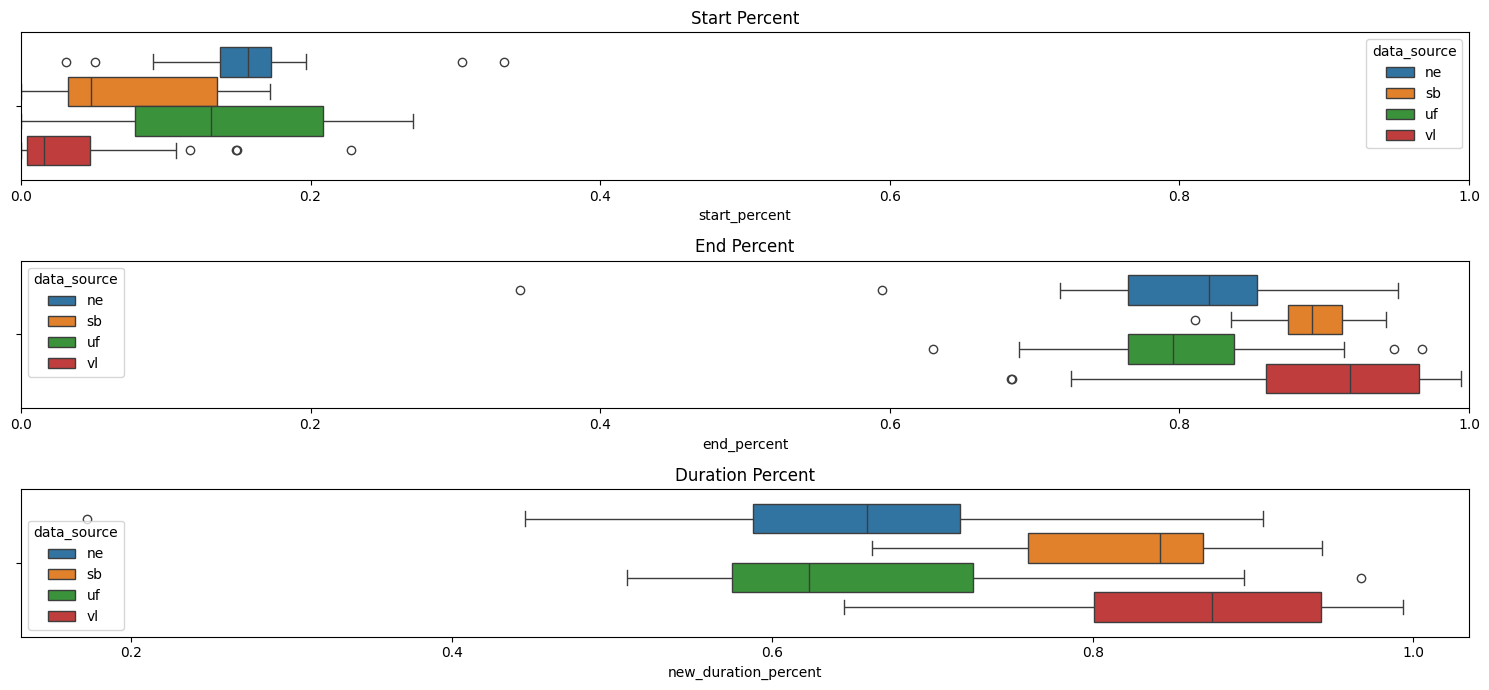

In [438]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))

sns.boxplot(data=threshold_df, x='start_percent', hue='data_source', ax=ax1)
ax1.set_title('Start Percent')
ax1.set_xlim(0, 1)

sns.boxplot(data=threshold_df, x='end_percent', hue='data_source', ax=ax2) 
ax2.set_title('End Percent')
ax2.set_xlim(0, 1)

sns.boxplot(data=threshold_df, x='new_duration_percent', hue='data_source', ax=ax3)
ax3.set_title('Duration Percent')

plt.tight_layout()

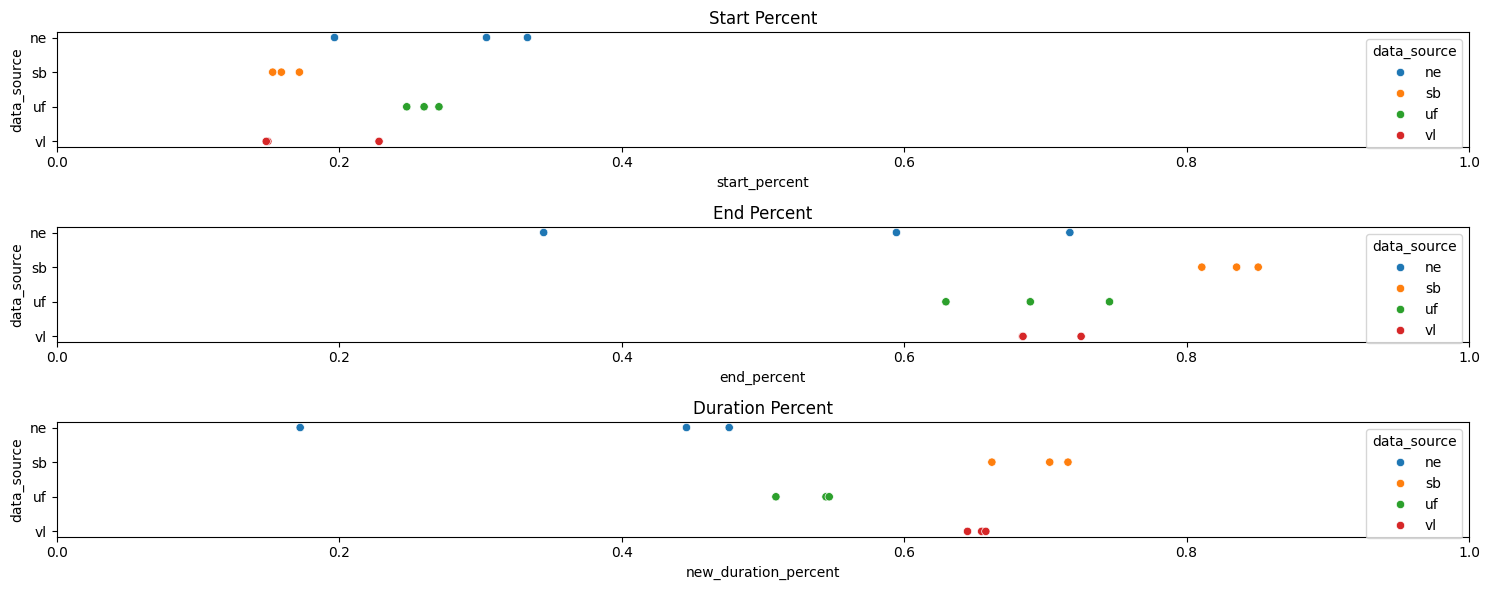

In [449]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 6))

sns.scatterplot(data=highest_starts_df, x='start_percent', y='data_source', hue='data_source', ax=ax1)
ax1.set_title('Start Percent')
ax1.set_xlim(0, 1)

sns.scatterplot(data=lowest_ends_df, x='end_percent', y='data_source', hue='data_source', ax=ax2) 
ax2.set_title('End Percent')
ax2.set_xlim(0, 1)

sns.scatterplot(data=shortest_durations_df, x='new_duration_percent', y='data_source', hue='data_source', ax=ax3)
ax3.set_title('Duration Percent')
ax3.set_xlim(0, 1)

plt.tight_layout()

#### Check latest starts

In [ ]:
gap = 0.2
for i, row in highest_starts_df.iterrows():
    video_path = f"{path_to_root}data/raw/combined/videos/{row.filename}"
    # get the start frame index, and the frame 1 tenth of a second before and after
    start_frame = row.start_frame
    end_frame = row.end_frame
    start_frame_before = start_frame - int(gap * row.fps)
    start_frame_after = start_frame + int(gap * row.fps)
    end_frame_before = end_frame - int(gap * row.fps)
    end_frame_after = end_frame + int(gap * row.fps)
    
    frames = [start_frame_before, start_frame, start_frame_after, end_frame_before, end_frame, end_frame_after]
    frames = [frame for frame in frames if frame >= 0 and frame < row.frame_count]
    
    md.show_multiple_frames_one_plot(video_path, frames, [mm_raw_dict[row.filename], mm_dict[row.filename]], legend_labels=['Raw', 'Moving Average'])
    results = md.plot_motion_with_peaks_and_slopes(
        motion_data=mm_dict[row.filename],
        fps=row.fps,
        start_buffer_seconds=0.15,
        end_buffer_seconds=0.15,
        fallback_simple_start_threshold=start_threshold,
        fallback_simple_end_threshold=end_threshold,
        figsize=(15, 3),
    )

    print(f"Peak Start Frame: {results['start_frame']}")
    print(f"Peak End Frame: {results['end_frame']}")
    

#### Check earliest ends

In [ ]:
gap = 0.2
for i, row in lowest_ends_df.iterrows():
    video_path = f"{path_to_root}data/raw/combined/videos/{row.filename}"
    # get the start frame index, and the frame 1 tenth of a second before and after
    start_frame = row.start_frame
    end_frame = row.end_frame
    start_frame_before = start_frame - int(gap * row.fps)
    start_frame_after = start_frame + int(gap * row.fps)
    end_frame_before = end_frame - int(gap * row.fps)
    end_frame_after = end_frame + int(gap * row.fps)
    
    frames = [start_frame_before, start_frame, start_frame_after, end_frame_before, end_frame, end_frame_after]
    frames = [frame for frame in frames if frame >= 0 and frame < row.frame_count]
    
    md.show_multiple_frames_one_plot(video_path, frames, [mm_raw_dict[row.filename], mm_dict[row.filename]], legend_labels=['Raw', 'Moving Average'])
    results = md.plot_motion_with_peaks_and_slopes(
        motion_data=mm_dict[row.filename],
        fps=row.fps,
        start_buffer_seconds=0.15,
        end_buffer_seconds=0.15,
        fallback_simple_start_threshold=start_threshold,
        fallback_simple_end_threshold=end_threshold,
        figsize=(15, 3),
    )

    print(f"Peak Start Frame: {results['start_frame']}")
    print(f"Peak End Frame: {results['end_frame']}")
    

#### Check shortest durations

In [ ]:
gap = 0.2
for i, row in shortest_durations_df.iterrows():
    video_path = f"{path_to_root}data/raw/combined/videos/{row.filename}"
    # get the start frame index, and the frame 1 tenth of a second before and after
    start_frame = row.start_frame
    end_frame = row.end_frame
    start_frame_before = start_frame - int(gap * row.fps)
    start_frame_after = start_frame + int(gap * row.fps)
    end_frame_before = end_frame - int(gap * row.fps)
    end_frame_after = end_frame + int(gap * row.fps)
    
    frames = [start_frame_before, start_frame, start_frame_after, end_frame_before, end_frame, end_frame_after]
    frames = [frame for frame in frames if frame >= 0 and frame < row.frame_count]
    
    md.show_multiple_frames_one_plot(video_path, frames, [mm_raw_dict[row.filename], mm_dict[row.filename]], legend_labels=['Raw', 'Moving Average'])
    results = md.plot_motion_with_peaks_and_slopes(
        motion_data=mm_dict[row.filename],
        fps=row.fps,
        start_buffer_seconds=0.15,
        end_buffer_seconds=0.15,
        fallback_simple_start_threshold=start_threshold,
        fallback_simple_end_threshold=end_threshold,
        figsize=(15, 3),
    )

    print(f"Peak Start Frame: {results['start_frame']}")
    print(f"Peak End Frame: {results['end_frame']}")
    